Hannah Weiser <br>
January 2023 <br>
Master's thesis
***

# Survey generation

Notebook for generating HELIOS++ surveys used in my Master thesis.

## Imports

In [1]:
from pathlib import Path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math

## Given filepaths

The scenes that shall be scanned are already generated by the `movingtree2helios` add-on, so here, we provide the directory, where all scenes that shall be used are located.

In [2]:
helios_root = "H:/helios"
scene_directory = "data/scenes/movingtrees"
survey_directory_tls = "data/surveys/movingtrees_tls"
Path(Path(helios_root) / survey_directory_tls).mkdir(parents=True, exist_ok=True)
survey_directory_uls = "data/surveys/movingtrees_uls"
Path(Path(helios_root) / survey_directory_uls).mkdir(parents=True, exist_ok=True)
scene_files = (Path(helios_root) / scene_directory).glob("*.xml")
scene_files = [f.as_posix() for f in scene_files]
scene_names = [Path(f).stem for f in scene_files]
survey_files_tls = [(Path(helios_root) / survey_directory_tls / f"tls_{name}.xml").as_posix() for name in scene_names]
survey_files_uls = [(Path(helios_root) / survey_directory_uls / f"uls_{name}.xml").as_posix() for name in scene_names]

## TLS survey

Let's first define a function for creating the scan positions for our survey.
The function gets a list of waypoints as input, as well as the id of the scanner template settings.
The position of the tree of interest is known, so we can derive the start and stop angles defining the field of view from the waypoints.

In [3]:
def rotate_around_point(xy, degrees, origin=(0, 0)):
    """Function to rotate an array of points around a given origin"""
    # convert degree to radians
    radians = math.radians(degrees)
    x = xy[:, 0]
    y = xy[:, 1]
    offset_x, offset_y = origin
    # first, transform x and y to the origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    # transform and translate back
    qx = offset_x + cos_rad * adjusted_x - sin_rad * adjusted_y
    qy = offset_y + sin_rad * adjusted_x + cos_rad * adjusted_y

    return np.array((qx, qy)).T


def get_wp_and_fov_from_xml(xml: str):
    """Get the waypoints and field of view from a (HELIOS++) XMl containing only the legs"""
    import xml.etree.ElementTree as ET
    import re
    tree = ET.fromstring("<root>\n" + xml + "</root>")
    x = []
    y = []
    head_rot_start = []
    head_rot_stop = []
    for leg in tree:
        for setting in leg:
            if setting.tag == "platformSettings":
                x.append(float(setting.attrib["x"]))
                y.append(float(setting.attrib["y"]))
            if setting.tag == "scannerSettings":
                head_rot_start.append(float(setting.attrib["headRotateStart_deg"]))
                head_rot_stop.append(float(setting.attrib["headRotateStop_deg"]))
    
    return (x, y, head_rot_start, head_rot_stop)

def plot_measurement_plan(xml_legs, object_position):
    """Plot the measurement plan for given legs (TLS case!)"""
    x, y, head_rot_start, head_rot_stop = get_wp_and_fov_from_xml(xml_legs)
    
    plt.axes().set_aspect('equal')
    scan_pos = plt.scatter(x, y, marker="x", color="black", label="Scan positions")
    tree_pos = plt.scatter(object_position[0], object_position[1], marker="*", color="g", label="Tree position", s=400)
    
    for x, y, start, stop in zip(x, y, head_rot_start, head_rot_stop):
        a = np.array([x, y])
        b = np.array([[x, y+5]])
        b1 = rotate_around_point(b, start, origin=a)
        b2 = rotate_around_point(b, stop, origin=a)
        line_b1 = np.vstack((a, b1))
        line_b2 = np.vstack((a, b2))
        plt.plot(line_b1[:, 0], line_b1[:, 1], color="grey", alpha=0.5)
        fov_line, = plt.plot(line_b2[:, 0], line_b2[:, 1], color="grey", alpha=0.5, label="Field of view")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("scaled")
    plt.legend(handles=[scan_pos, tree_pos, fov_line], bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    #plt.legend(handles=[scan_pos, tree_pos, fov_line], loc="upper right")
    plt.show()

def create_legs_tls(waypoints, scanner_template, tree_pos = (0, 0), fov_deg=90, plot=False):
    legs = ""
    
    for wp in waypoints:
        # from waypoint position, derive the necessary waypoints for the FOV (always 90°)
        vec = np.array(tree_pos) - wp  # vector from waypoint to tree position
        direction = -np.rad2deg(np.arctan2(vec[0], vec[1]))  # get direction angle
        # get start and stop angle
        rot_start = direction - fov_deg/2
        rot_stop = direction + fov_deg/2
        
        legs += f'''<leg>
            <platformSettings x="{wp[0]:.4f}" y="{wp[1]:.4f}" z="0" onGround="true"/>
            <scannerSettings template="{scanner_template}" headRotateStart_deg="{rot_start:.4f}" headRotateStop_deg="{rot_stop:.4f}" trajectoryTimeInterval_s="0.05"/>
        </leg>
'''
    
    if plot:
        plot_measurement_plan(legs, tree_pos)
        
    return legs

Let's also define a function to get the scene ID from a scene file.

In [4]:
def get_scene_id(scene_path):
    import xml.etree.ElementTree as ET
    import re
    tree = ET.parse(scene_path)
    root = tree.getroot()
    for child in root:
        if child.tag == "scene":
            scene_id = child.attrib["id"]
            break
    
    return scene_id

Next, we write a function which creates the TLS survey file for given parameters, including the legs. 

In [5]:
def create_survey_tls(survey_name,
                      scanner_template_id,
                      pulse_freq,
                      vertical_res,
                      horizontal_res,
                      scanner_id,
                      scene,
                      scene_id,
                      legs):
    tls_survey_content = f'''<?xml version="1.0" encoding="UTF-8"?>
    <document>
        <scannerSettings id="{scanner_template_id}" active="true" pulseFreq_hz="{pulse_freq}" verticalResolution_deg="{vertical_res}" horizontalResolution_deg="{horizontal_res}"/>
        <survey name="{survey_name}" platform="data/platforms.xml#tripod" scanner="data/scanners_tls.xml#{scanner_id}" scene="{scene}#{scene_id}">
            {legs}
        </survey>
    </document>
    '''
    
    return tls_survey_content

Let's bring it together and create our survey file.
In this example, we create 6 scan positions regularly distributed around the tree.

In [6]:
def circle_points(r, n):
    """Create n points on a circle with radius r (centered at the origin)"""
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.c_[x, y]

In [7]:
n_scan_pos = 6
distance_tree = 3
waypoints = circle_points(distance_tree, n_scan_pos)
scanner_templ_id = "tls"

We also plot the flight plan that we configured.

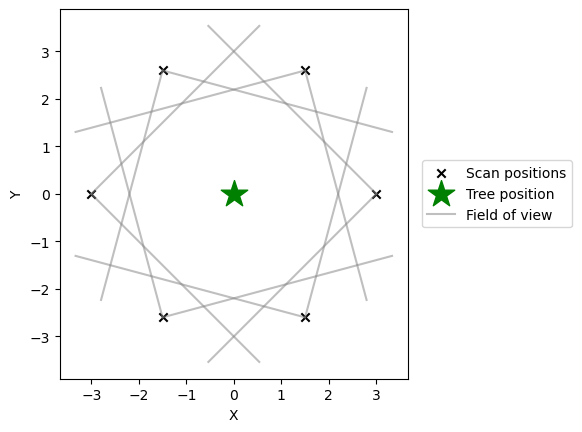

<leg>
            <platformSettings x="3.0000" y="0.0000" z="0" onGround="true"/>
            <scannerSettings template="tls" headRotateStart_deg="45.0000" headRotateStop_deg="135.0000" trajectoryTimeInterval_s="0.05"/>
        </leg>
<leg>
            <platformSettings x="1.5000" y="2.5981" z="0" onGround="true"/>
            <scannerSettings template="tls" headRotateStart_deg="105.0000" headRotateStop_deg="195.0000" trajectoryTimeInterval_s="0.05"/>
        </leg>
<leg>
            <platformSettings x="-1.5000" y="2.5981" z="0" onGround="true"/>
            <scannerSettings template="tls" headRotateStart_deg="-195.0000" headRotateStop_deg="-105.0000" trajectoryTimeInterval_s="0.05"/>
        </leg>
<leg>
            <platformSettings x="-3.0000" y="0.0000" z="0" onGround="true"/>
            <scannerSettings template="tls" headRotateStart_deg="-135.0000" headRotateStop_deg="-45.0000" trajectoryTimeInterval_s="0.05"/>
        </leg>
<leg>
            <platformSettings x="-1.5000" y="-

In [8]:
legs = create_legs_tls(waypoints, scanner_templ_id, plot=True)
print(legs)

Finally, we have to define the scan settings and the files where to write the surveys.

In [ ]:
pulse_freq = 600_000
vertical_resolution = 0.04
horizontal_resolution = 0.04
scanner_id = "riegl_vz400"

In [ ]:
for scene, survey in zip(scene_files, survey_files_tls):
    scene_relative = Path(scene).relative_to(helios_root).as_posix()
    scene_id = get_scene_id(scene)
    survey_name = f"{scene_id}_tls"
    survey_content = create_survey_tls(survey_name,
                                       scanner_templ_id,
                                       pulse_freq,
                                       vertical_resolution,
                                       horizontal_resolution,
                                       scanner_id,
                                       scene_relative,
                                       scene_id,
                                       legs)

    with open(survey, "w") as f:
        f.write(survey_content)

Let's have a look at the content of the very last survey:

In [ ]:
print(survey_content)

## ULS survey

The ULS survey is a moving platform and therefore needs different configuration parameters. Here, we decide to use a real trajectory, which was translated to the origin, as "template". Let's first load the trajectory points.

In [9]:
uls_traj_file1 = "../data/uls_traj1_full.txt"
uls_traj_file2 = "../data/uls_traj2_full.txt"
uls_traj1 = np.loadtxt(uls_traj_file1, delimiter=" ", comments="//")
uls_traj2 = np.loadtxt(uls_traj_file2, delimiter=" ", comments="//")
# trajectories are normalized, so let's add the flying height
flight_altitude = 15
uls_traj1[:, 2] += flight_altitude
uls_traj2[:, 2] += flight_altitude

As we are only scanning one single tree, let's clip the trajectory by a bounding box:

In [10]:
def clip_by_aabb(pc, aabb):
    """Clip a point cloud (stored in numpy array) by a given 2D axis-aligned bounding box [xmin, ymin, xmax, ymax]"""
    assert len(aabb) == 4
    x_min, y_min, x_max, y_max = aabb
    subset = pc[(pc[:, 0] > x_min) & 
                 (pc[:, 0] < x_max) & 
                 (pc[:, 1] > y_min) & 
                 (pc[:, 1] < y_max)]
    
    return subset

In [11]:
bbox = [-5, -5, 5, 5]
uls_traj1_c = clip_by_aabb(uls_traj1, bbox)
uls_traj2_c = clip_by_aabb(uls_traj2, bbox)

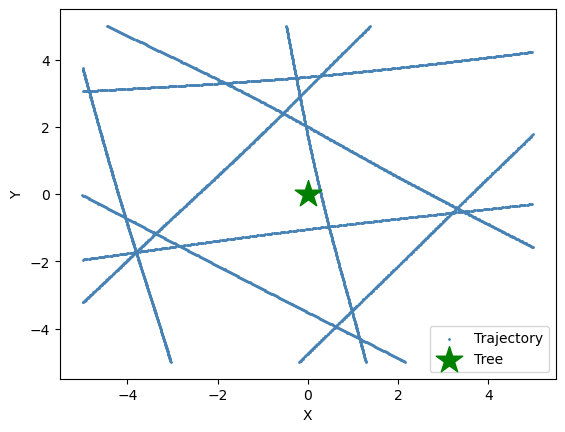

In [20]:
plt.scatter(uls_traj1_c[:, 0], uls_traj1_c[:, 1], s=1, c="steelblue")
plt.scatter(uls_traj2_c[:, 0], uls_traj2_c[:, 1], s=1, c="steelblue", label="Trajectory")
plt.scatter([0], [0], marker="*", s=400, c="g", label="Tree")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

In [13]:
# write clipped trajectory to file
uls_traj_file1_c = "data/trajectories/uls_traj1.txt"
uls_traj_file2_c = "data/trajectories/uls_traj2.txt"

np.savetxt(Path(helios_root) / uls_traj_file1_c, uls_traj1_c, fmt='%.6f', delimiter=',')
np.savetxt(Path(helios_root) / uls_traj_file2_c, uls_traj2_c, fmt='%.6f', delimiter=',')

In [ ]:
# get time gaps in trajectory
def get_gaps(arr):
    idxs = np.where(np.diff(arr) > 1)[0]
    gap_times_start = list(zip(arr[idxs+1], arr[idxs+1]))
    gap_times_start = np.unique(np.array(gap_times_start).flatten())
    gap_times_start = np.insert(gap_times_start, 0, arr[0])
    gap_times_end = list(zip(arr[idxs], arr[idxs]))
    gap_times_end = np.unique(np.array(gap_times_end).flatten())
    gap_times_end = np.append(gap_times_end, arr[-1])
    
    return gap_times_start, gap_times_end

In [ ]:
gap_times1_s, gap_times1_e = get_gaps(uls_traj1_c[:, 3])
gap_times2_s, gap_times2_e = get_gaps(uls_traj2_c[:, 3])

Configure the legs using the trajectory. Using the time gap info, split the whole trajectory into separate flight strips.

In [ ]:
scanner_templ_id = "uls"
pulse_freq = 300_000
scan_freq = 100
scanner_id = "riegl_vux-1uav22"
slope_filter_threshold = 10

In [ ]:
legs = f'''
        <leg>
            <platformSettings 
                trajectory="{uls_traj_file1_c}" teleportToStart="true"
                tIndex="3" xIndex="0" yIndex="1" zIndex="2" rollIndex="4" pitchIndex="5" yawIndex="6"
                slopeFilterThreshold="{slope_filter_threshold}" toRadians="true" syncGPSTime="true"
                tStart="{gap_times1_s[0]}" tEnd="{gap_times1_e[0]}"
            />
            <scannerSettings template="{scanner_templ_id}" trajectoryTimeInterval_s="0.03"/>
        </leg>
       '''

for i in range(1, len(gap_times1_s)):
    legs += f'''
        <leg>
            <platformSettings 
                trajectory="{uls_traj_file1_c}" teleportToStart="true"
                slopeFilterThreshold="{slope_filter_threshold}" toRadians="true" syncGPSTime="true"
                tStart="{gap_times1_s[i]}" tEnd="{gap_times1_e[i]}"
            />
            <scannerSettings template="{scanner_templ_id}" trajectoryTimeInterval_s="0.03"/>
        </leg>
       '''

legs += f'''
        <leg>
            <platformSettings 
                trajectory="{uls_traj_file2_c}" teleportToStart="true"
                tIndex="3" xIndex="0" yIndex="1" zIndex="2" rollIndex="4" pitchIndex="5" yawIndex="6"
                slopeFilterThreshold="{slope_filter_threshold}" toRadians="true" syncGPSTime="true"
                tStart="{gap_times1_s[0]}" tEnd="{gap_times2_e[0]}"
            />
            <scannerSettings template="{scanner_templ_id}" trajectoryTimeInterval_s="0.03"/>
        </leg>
       '''

for i in range(1, len(gap_times2_s)):
    legs += f'''
        <leg>
            <platformSettings 
                trajectory="{uls_traj_file2_c}" teleportToStart="true"
                slopeFilterThreshold="{slope_filter_threshold}" toRadians="true" syncGPSTime="true"
                tStart="{gap_times1_s[i]}" tEnd="{gap_times1_e[i]}"
            />
            <scannerSettings template="{scanner_templ_id}" trajectoryTimeInterval_s="0.03"/>
        </leg>
       '''

print(legs)

In [ ]:
def create_survey_uls(survey_name,
                      scanner_template_id,
                      pulse_freq,
                      scan_freq,
                      scanner_id,
                      scene,
                      scene_id,
                      legs):
    uls_survey_content = f'''<?xml version="1.0" encoding="UTF-8"?>
    <document>
        <scannerSettings id="{scanner_template_id}" active="true" pulseFreq_hz="{pulse_freq}" scanFreq_hz="{scan_freq}" />
        <survey name="{survey_name}" platform="interpolated" baseplatform="copter_linearpath" scanner="data/scanners_als.xml#{scanner_id}" scene="{scene}#{scene_id}">
            {legs}
        </survey>
    </document>
    '''
    
    return uls_survey_content

In [ ]:
for scene, survey in zip(scene_files, survey_files_uls):
    scene_relative = Path(scene).relative_to(helios_root).as_posix()
    scene_id = get_scene_id(scene)
    survey_name = f"{scene_id}_uls"
    survey_content = create_survey_uls(survey_name,
                                       scanner_templ_id,
                                       pulse_freq,
                                       scan_freq,
                                       scanner_id,
                                       scene_relative,
                                       scene_id,
                                       legs)

    with open(survey, "w") as f:
        f.write(survey_content)